In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/jovyan/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.BruteForceEstimator as bfEstimator
import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc

from src.visualization import SamplingMethod, BFmethod
from src.data_processing.SampleEstimator import SampleEstimator
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


2025-02-19 07:51:53,395 [INFO] Previous sample images loaded....
2025-02-19 07:51:53,402 [INFO] Generating image product matrix....
2025-02-19 07:51:54,795 [INFO] Generating embeddings....
1149


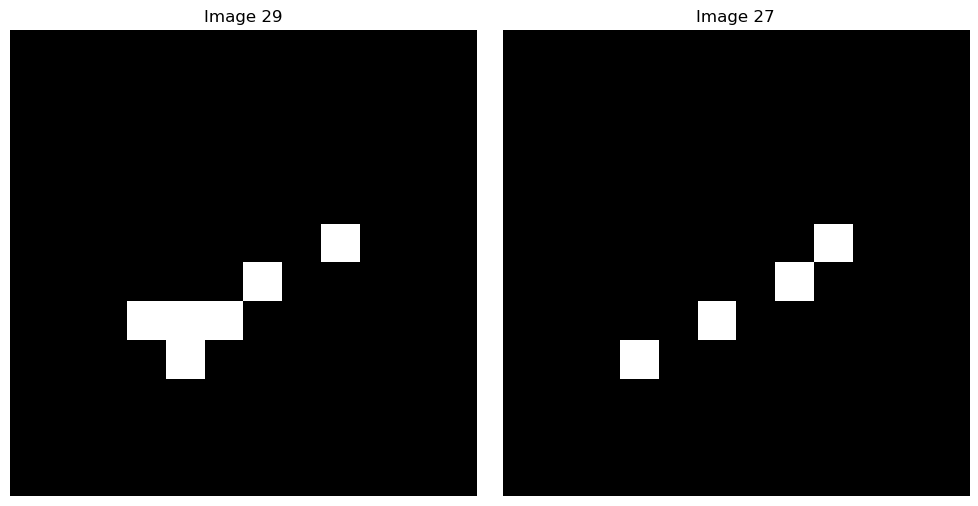

In [39]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 512

imageType = "shapes_3_dims_6_3" #6x6 triangle in 12x12 matrix shapes_3_dims_6_3
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k=5
percentage = 0.1

imageSet = utils.generate_filtered_image_set(imageType, filters, Futils.get_image_set_filepath(imageType, filters))
imageSet = np.array(imageSet)

sampleName = f"{imageType} {filters} {percentage} sample"

sampleEstimator = SampleEstimator(sampleName=sampleName, embeddingType=embeddingType, imageProductType=imageProductType)
#print(len(sampleEstimator.trainingImageSet))
testSample = np.array([img for img in imageSet if not np.any([np.array_equal(img, train_img) for train_img in sampleEstimator.trainingImageSet])])
#brute force one more image for dimension 128 T-T
# testSample = np.append(testSample, [sampleEstimator.trainingImageSet[50]], axis=0)

index1 = np.random.randint(len(testSample))
index2 = np.random.randint(len(testSample))

input1=testSample[index1]
input2=testSample[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

# ------------------------- Preprocessing Dataset ------------------------
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]

In [4]:
model = models.SimpleCNN(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                                               f'best_model_{imageType}_{dimensions}d_2.pt')))
model.eval()

/tmp/ipykernel_17667/194500836.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model",


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (relu): ReLU()
      )
    )
  )
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAv

In [6]:
#----------------------Metric 1 - Loss Calculation-----------------
NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[index1])
embedded_vector_image2 = model(input_dataset[index2])

dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)

print("Dot product value of model: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("Difference in values of BF Method and Model Method: ", difference.item())


Loss Calculation

Scaled NCC:  0.15470051765441895
Dot product value of model:  0.08786562830209732
Loss:  0.06683488935232162

Dot product value of BF Method:  0.1258479856974567
Loss:  0.028852537274360657
Difference in values of BF Method and Model Method:  0.03798235207796097


----------------
Brute Force Method -- KNN-IOU score
----------------
Estimating K-Score for Image 510: K-Score = 0.625
Intersection sets : [312 321 491 509 510]
Union sets: [310 312 313 321 322 491 509 510]

Top 8 values of Vector b
Rank 1: Value = 1.0, Index = 510
Rank 2: Value = 0.8973665237426758, Index = 321
Rank 3: Value = 0.7999999523162842, Index = 491
Rank 4: Value = 0.7999999523162842, Index = 509
Rank 5: Value = 0.7888543605804443, Index = 312
Rank 6: Value = 0.7162326574325562, Index = 313
Rank 7: Value = 0.7162326574325562, Index = 322
Rank 8: Value = 0.6865478754043579, Index = 310

Top 8 values of Vector c
Rank 1: Value = 1.0, Index = 510
Rank 2: Value = 0.9422138172320567, Index = 321
Rank 3: Value = 0.8865534255787866, Index = 509
Rank 4: Value = 0.8733557972652205, Index = 312
Rank 5: Value = 0.8696112700483897, Index = 491
Rank 6: Value = 0.7952051185997004, Index = 310
Rank 7: Value = 0.7805801548556803, Index = 505
Rank 8: Value = 0.6995559049148314, Index = 322

C

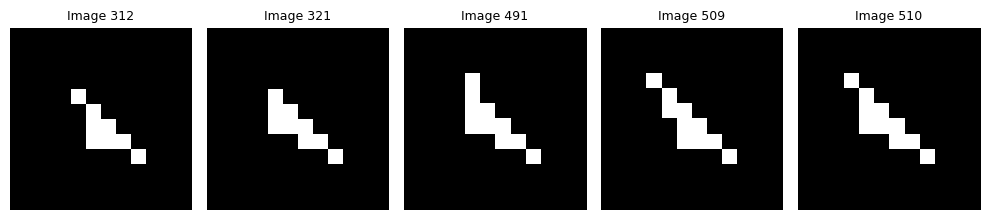


Plotting images in the union set:


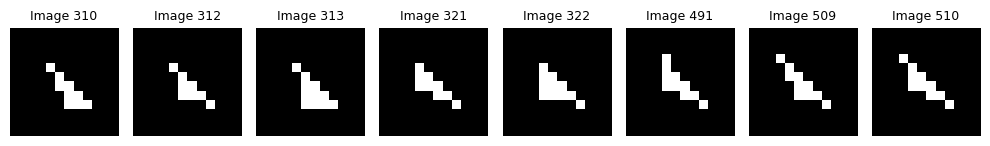


For translationally unique plots: 
Image 310 has no translationally similar images.
Image 312 has no translationally similar images.
Image 313 has no translationally similar images.
Image 321 has no translationally similar images.
Image 322 has no translationally similar images.
Image 491 has no translationally similar images.
Image 509 has no translationally similar images.
Image 510 has no translationally similar images.

Plotting images in the intersection set:


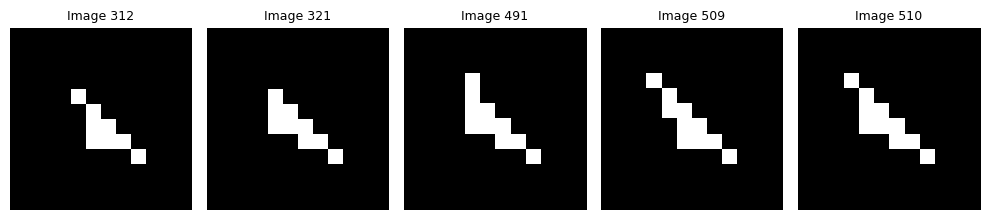


Plotting images in the union set:


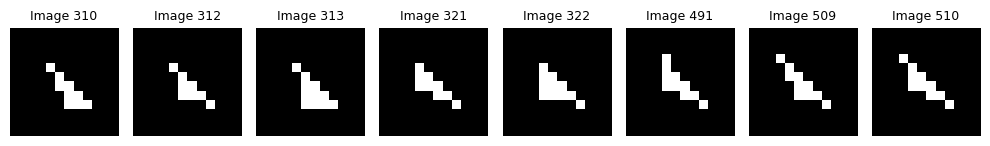

Estimating K-Score for Image 255: K-Score = 0.2
Intersection sets : [255 256]
Union sets: [134 214 254 255 256 407 409 410 423 436]

Top 10 values of Vector b
Rank 1: Value = 1.0, Index = 255
Rank 2: Value = 0.7888543605804443, Index = 256
Rank 3: Value = 0.732050895690918, Index = 134
Rank 4: Value = 0.732050895690918, Index = 254
Rank 5: Value = 0.6329931020736694, Index = 410
Rank 6: Value = 0.6329931020736694, Index = 423
Rank 7: Value = 0.6329929828643799, Index = 258
Rank 8: Value = 0.5118579864501953, Index = 257
Rank 9: Value = 0.5118579864501953, Index = 411
Rank 10: Value = 0.5118578672409058, Index = 413

Top 10 values of Vector c
Rank 1: Value = 1.0, Index = 255
Rank 2: Value = 0.9053950190249881, Index = 409
Rank 3: Value = 0.8046281775596817, Index = 407
Rank 4: Value = 0.7470679816143133, Index = 214
Rank 5: Value = 0.7434913086560226, Index = 436
Rank 6: Value = 0.7148378015532857, Index = 256
Rank 7: Value = 0.708214509420509, Index = 408
Rank 8: Value = 0.685653897660

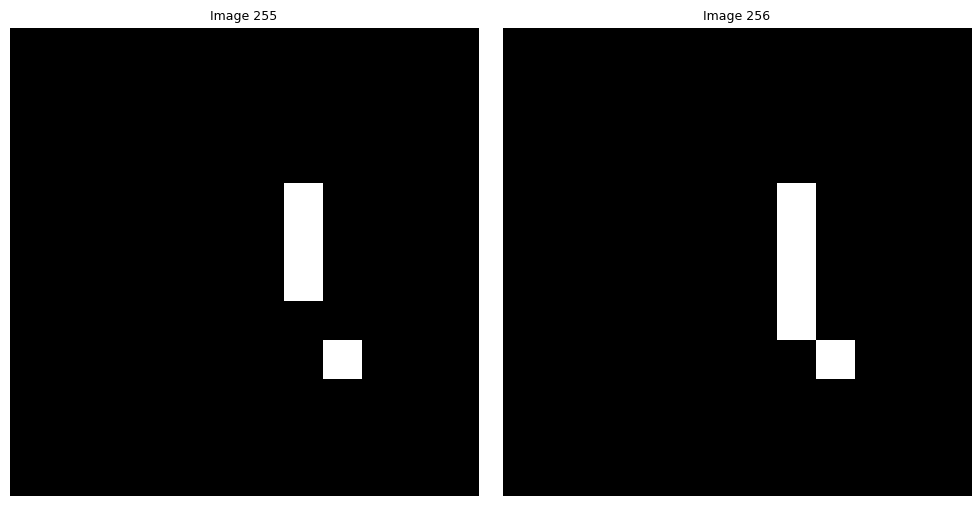


Plotting images in the union set:


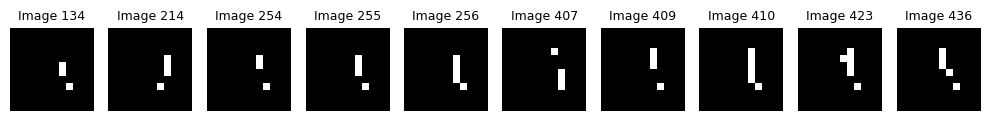


For translationally unique plots: 
Image 134 has no translationally similar images.
Image 214 has no translationally similar images.
Image 254 has no translationally similar images.
Image 255 has no translationally similar images.
Image 256 has no translationally similar images.
Image 407 has no translationally similar images.
Image 409 has no translationally similar images.
Image 410 has no translationally similar images.
Image 423 has no translationally similar images.
Image 436 has no translationally similar images.

Plotting images in the intersection set:


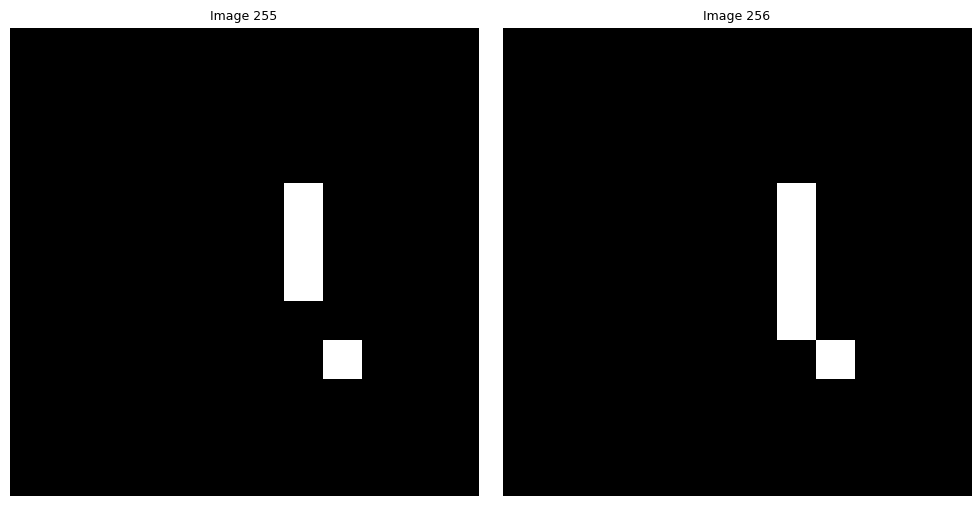


Plotting images in the union set:


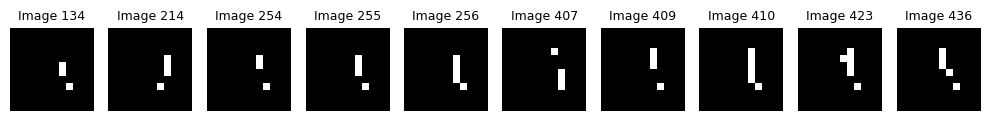

----------------
Model Method -- KNN-IOU score
----------------
Estimating K-Score for Image 510: K-Score = 0.625
Intersection sets : [312 321 491 509 510]
Union sets: [312 313 321 322 338 491 509 510]

Top 8 values of Vector b
Rank 1: Value = 1.0, Index = 510
Rank 2: Value = 0.8973665237426758, Index = 321
Rank 3: Value = 0.7999999523162842, Index = 491
Rank 4: Value = 0.7999999523162842, Index = 509
Rank 5: Value = 0.7888543605804443, Index = 312
Rank 6: Value = 0.7162326574325562, Index = 313
Rank 7: Value = 0.7162326574325562, Index = 322
Rank 8: Value = 0.6865478754043579, Index = 310

Top 8 values of Vector c
Rank 1: Value = 0.9999999403953552, Index = 510
Rank 2: Value = 0.9541637897491455, Index = 321
Rank 3: Value = 0.9306585788726807, Index = 338
Rank 4: Value = 0.92866450548172, Index = 312
Rank 5: Value = 0.9232878088951111, Index = 491
Rank 6: Value = 0.9224587678909302, Index = 509
Rank 7: Value = 0.9178400039672852, Index = 322
Rank 8: Value = 0.9178149700164795, Index =

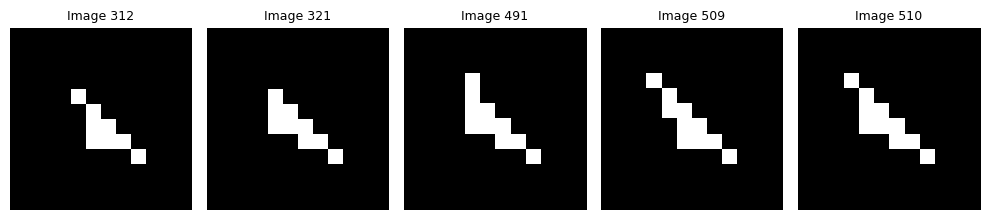


Plotting images in the union set:


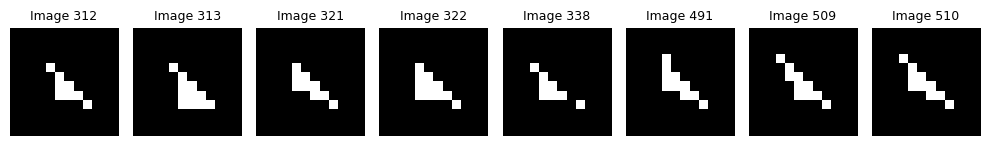


For translationally unique plots: 
Image 312 has no translationally similar images.
Image 313 has no translationally similar images.
Image 321 has no translationally similar images.
Image 322 has no translationally similar images.
Image 338 has no translationally similar images.
Image 491 has no translationally similar images.
Image 509 has no translationally similar images.
Image 510 has no translationally similar images.

Plotting images in the intersection set:


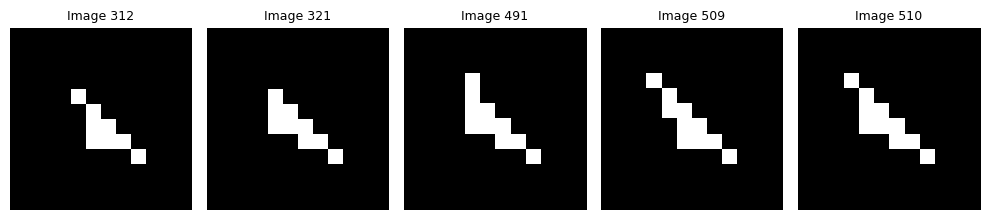


Plotting images in the union set:


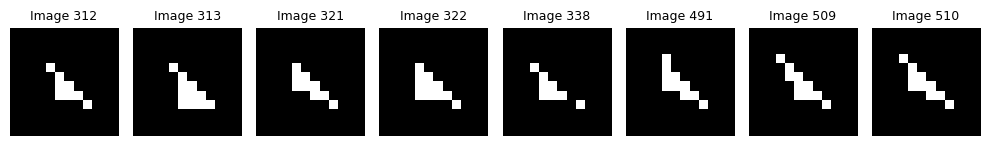

Estimating K-Score for Image 255: K-Score = 0.2
Intersection sets : [254 255]
Union sets: [ 57 134 210 214 254 255 256 277 410 423]

Top 10 values of Vector b
Rank 1: Value = 1.0, Index = 255
Rank 2: Value = 0.7888543605804443, Index = 256
Rank 3: Value = 0.732050895690918, Index = 134
Rank 4: Value = 0.732050895690918, Index = 254
Rank 5: Value = 0.6329931020736694, Index = 410
Rank 6: Value = 0.6329931020736694, Index = 423
Rank 7: Value = 0.6329929828643799, Index = 258
Rank 8: Value = 0.5118579864501953, Index = 257
Rank 9: Value = 0.5118579864501953, Index = 411
Rank 10: Value = 0.5118578672409058, Index = 413

Top 10 values of Vector c
Rank 1: Value = 0.9999998807907104, Index = 255
Rank 2: Value = 0.8744187951087952, Index = 214
Rank 3: Value = 0.7521440982818604, Index = 57
Rank 4: Value = 0.743736743927002, Index = 254
Rank 5: Value = 0.7259241342544556, Index = 277
Rank 6: Value = 0.7162793874740601, Index = 210
Rank 7: Value = 0.7046606540679932, Index = 134
Rank 8: Value = 

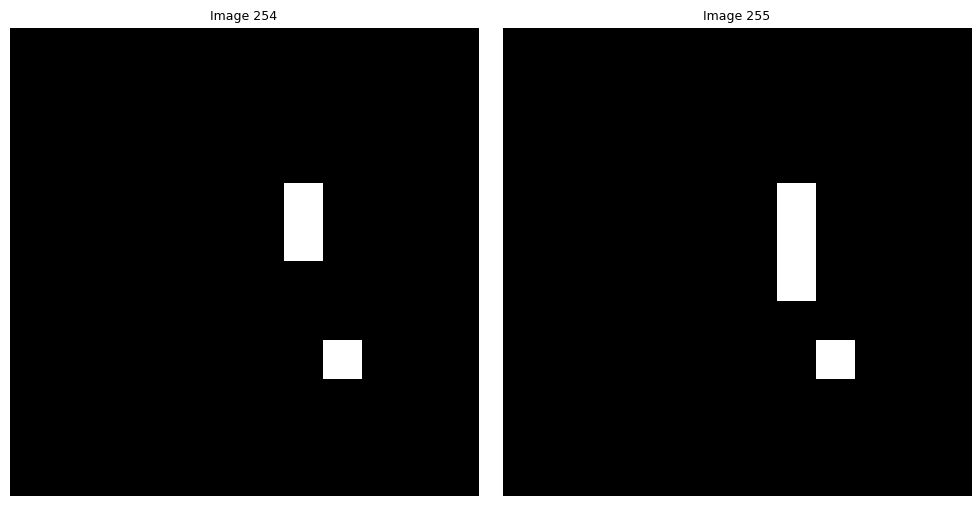


Plotting images in the union set:


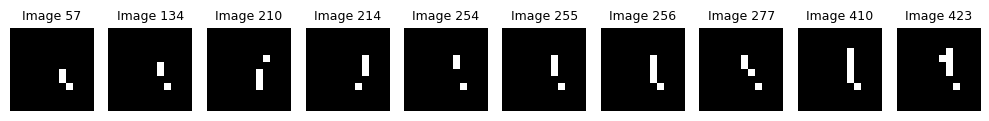


For translationally unique plots: 
Image 57 has no translationally similar images.
Image 134 has no translationally similar images.
Image 210 has no translationally similar images.
Image 214 has no translationally similar images.
Image 254 has no translationally similar images.
Image 255 has no translationally similar images.
Image 256 has no translationally similar images.
Image 277 has no translationally similar images.
Image 410 has no translationally similar images.
Image 423 has no translationally similar images.

Plotting images in the intersection set:


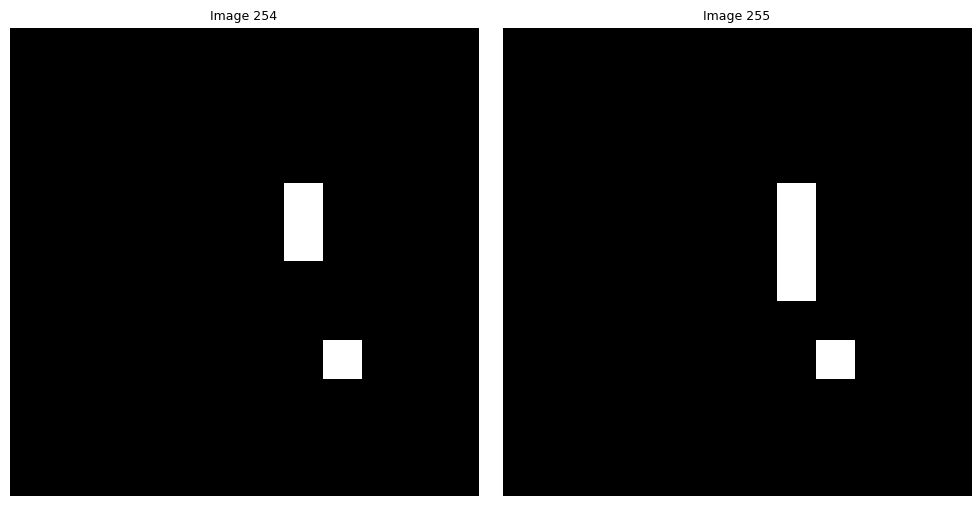


Plotting images in the union set:


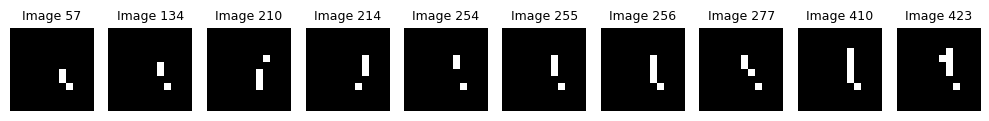

In [6]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, testSample)

vectorb_bf2 = matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, testSample)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, testSample)

vectorb_model2 = matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, testSample)


NCC Interval		Average Loss
-0.1-0.0		0.2645 (17037 samples)
-0.2--0.1		0.2606 (21981 samples)
-0.3--0.2		0.2618 (9175 samples)
-0.4--0.3		0.3704 (4880 samples)
-0.5--0.4		0.5008 (3318 samples)
-0.6--0.5		0.3782 (1700 samples)
-0.7--0.6		0.5044 (130 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2980 (31235 samples)
0.1-0.2		0.2965 (19574 samples)
0.2-0.3		0.3026 (15980 samples)
0.3-0.4		0.2570 (9036 samples)
0.4-0.5		0.2573 (6081 samples)
0.5-0.6		0.2223 (3692 samples)
0.6-0.7		0.1907 (1907 samples)
0.7-0.8		0.1851 (956 samples)
0.8-0.9		0.1293 (344 samples)
0.9-1.0		0.0051 (430 samples)


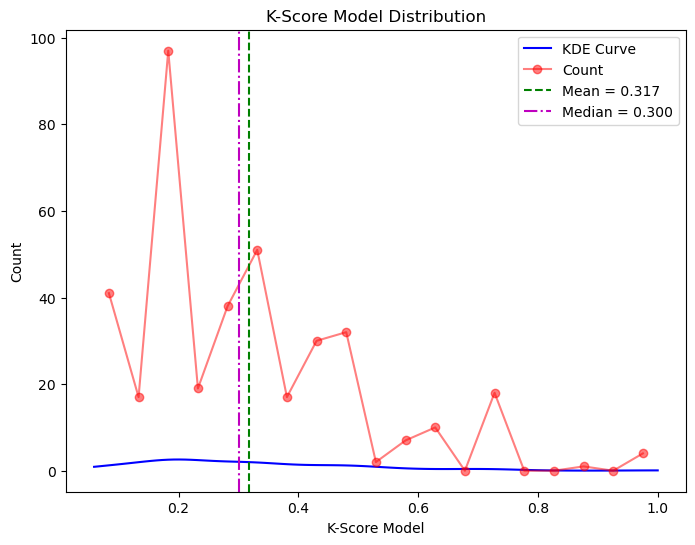

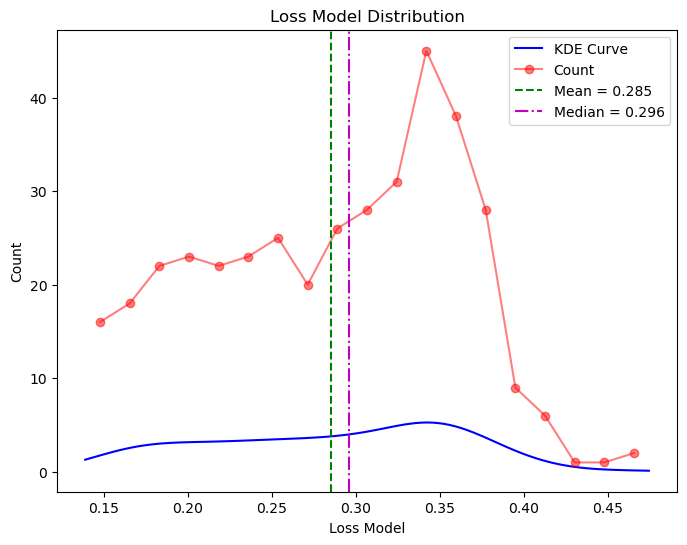


NCC Interval		Average Loss
-0.1-0.0		0.0553 (17037 samples)
-0.2--0.1		0.0673 (21981 samples)
-0.3--0.2		0.0755 (9175 samples)
-0.4--0.3		0.0981 (4880 samples)
-0.5--0.4		0.1843 (3318 samples)
-0.6--0.5		0.2047 (1700 samples)
-0.7--0.6		0.2432 (130 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0580 (31235 samples)
0.1-0.2		0.0623 (19574 samples)
0.2-0.3		0.0646 (15980 samples)
0.3-0.4		0.0732 (9036 samples)
0.4-0.5		0.0676 (6081 samples)
0.5-0.6		0.0709 (3692 samples)
0.6-0.7		0.0685 (1907 samples)
0.7-0.8		0.0690 (956 samples)
0.8-0.9		0.0582 (344 samples)
0.9-1.0		0.0032 (430 samples)


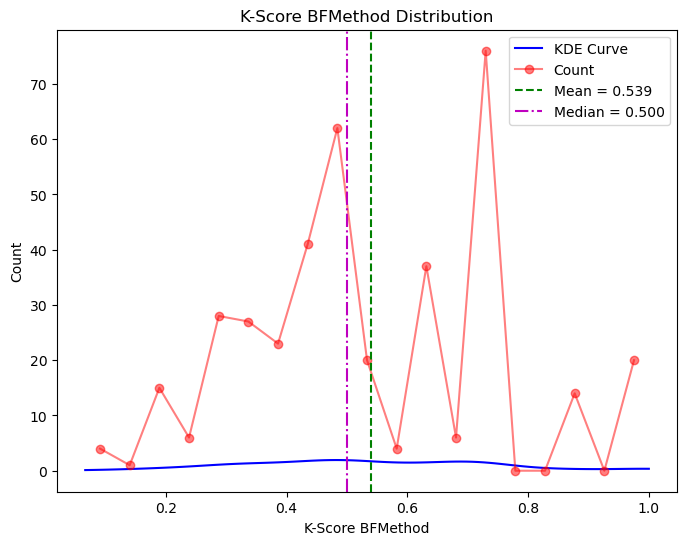

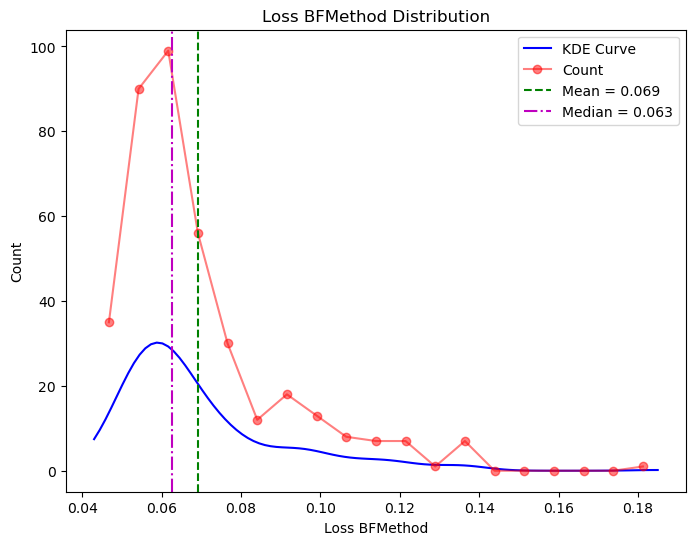

In [6]:
#--------------------Visualisation across dataset using model-------------------
kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_model(testSample, input_dataset, model, k)

imgcalc.loss_per_ncc_score(ncc_loss_dict)
imgplt.plot_score_distribution(kscores, "K-Score Model")
imgplt.plot_score_distribution(losses, "Loss Model")

kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)

imgcalc.loss_per_ncc_score(ncc_loss_dict)
imgplt.plot_score_distribution(kscores, "K-Score BFMethod")
imgplt.plot_score_distribution(losses, "Loss BFMethod")

Dimension 32

NCC Interval		Average Loss
-0.1-0.0		0.3149 (34419 samples)
-0.2--0.1		0.3025 (39702 samples)
-0.3--0.2		0.3037 (18130 samples)
-0.4--0.3		0.3769 (10188 samples)
-0.5--0.4		0.4991 (5584 samples)
-0.6--0.5		0.3652 (2824 samples)
-0.7--0.6		0.5415 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.3481 (56807 samples)
0.1-0.2		0.3447 (37318 samples)
0.2-0.3		0.3401 (29110 samples)
0.3-0.4		0.2830 (15625 samples)
0.4-0.5		0.2681 (10735 samples)
0.5-0.6		0.2293 (6430 samples)
0.6-0.7		0.1945 (3432 samples)
0.7-0.8		0.1707 (1584 samples)
0.8-0.9		0.1173 (608 samples)
0.9-1.0		0.0084 (611 samples)


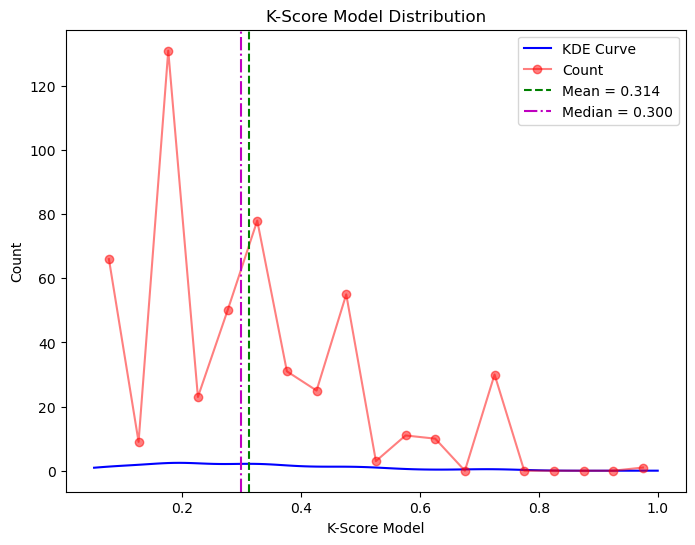

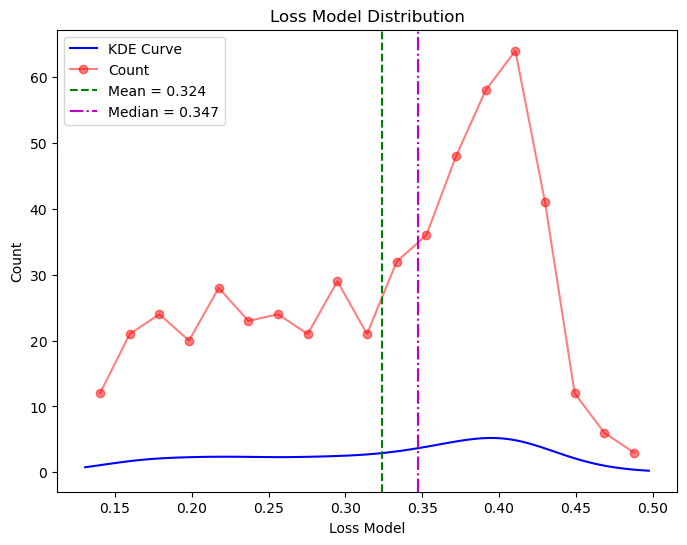


NCC Interval		Average Loss
-0.1-0.0		0.0553 (34419 samples)
-0.2--0.1		0.0685 (39702 samples)
-0.3--0.2		0.0803 (18130 samples)
-0.4--0.3		0.0974 (10188 samples)
-0.5--0.4		0.1925 (5584 samples)
-0.6--0.5		0.2224 (2824 samples)
-0.7--0.6		0.2597 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0580 (56807 samples)
0.1-0.2		0.0615 (37318 samples)
0.2-0.3		0.0634 (29110 samples)
0.3-0.4		0.0717 (15625 samples)
0.4-0.5		0.0685 (10735 samples)
0.5-0.6		0.0739 (6430 samples)
0.6-0.7		0.0695 (3432 samples)
0.7-0.8		0.0681 (1584 samples)
0.8-0.9		0.0594 (608 samples)
0.9-1.0		0.0046 (611 samples)


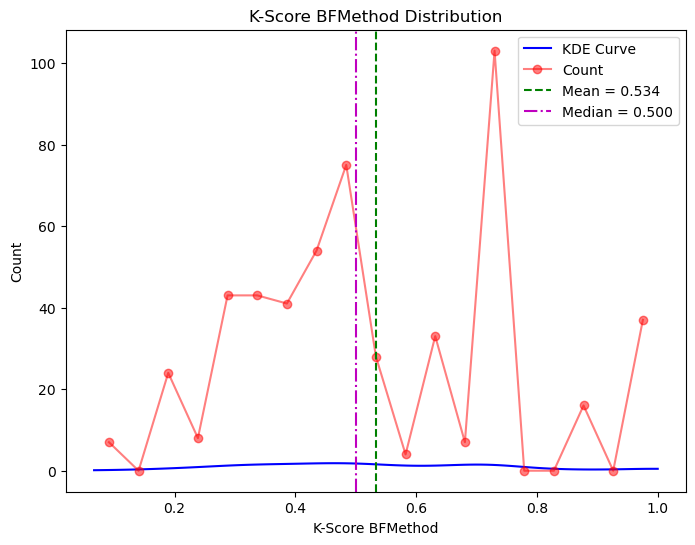

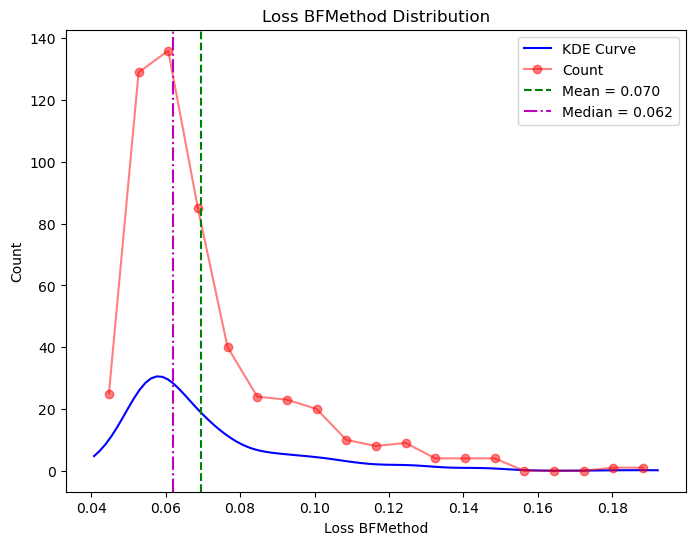

Dimension 64

NCC Interval		Average Loss
-0.1-0.0		0.2272 (34419 samples)
-0.2--0.1		0.2932 (39702 samples)
-0.3--0.2		0.2828 (18130 samples)
-0.4--0.3		0.3083 (10188 samples)
-0.5--0.4		0.7497 (5584 samples)
-0.6--0.5		0.8069 (2824 samples)
-0.7--0.6		0.6043 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2311 (56807 samples)
0.1-0.2		0.2235 (37318 samples)
0.2-0.3		0.2202 (29110 samples)
0.3-0.4		0.2100 (15625 samples)
0.4-0.5		0.2089 (10735 samples)
0.5-0.6		0.1985 (6430 samples)
0.6-0.7		0.1669 (3432 samples)
0.7-0.8		0.1594 (1584 samples)
0.8-0.9		0.1098 (608 samples)
0.9-1.0		0.0057 (611 samples)


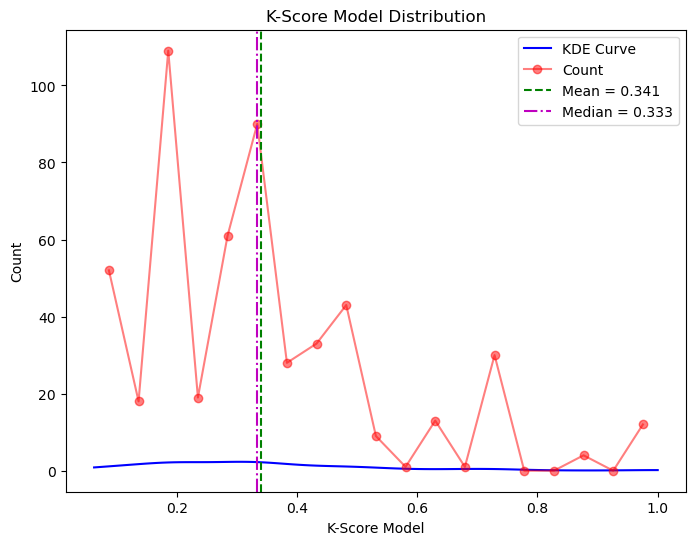

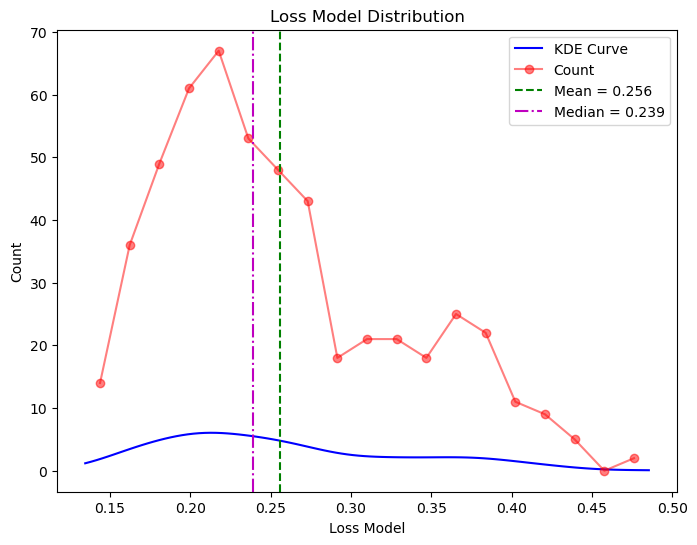


NCC Interval		Average Loss
-0.1-0.0		0.0463 (34419 samples)
-0.2--0.1		0.0639 (39702 samples)
-0.3--0.2		0.0840 (18130 samples)
-0.4--0.3		0.1057 (10188 samples)
-0.5--0.4		0.2103 (5584 samples)
-0.6--0.5		0.2454 (2824 samples)
-0.7--0.6		0.2773 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0456 (56807 samples)
0.1-0.2		0.0472 (37318 samples)
0.2-0.3		0.0497 (29110 samples)
0.3-0.4		0.0587 (15625 samples)
0.4-0.5		0.0557 (10735 samples)
0.5-0.6		0.0610 (6430 samples)
0.6-0.7		0.0576 (3432 samples)
0.7-0.8		0.0659 (1584 samples)
0.8-0.9		0.0534 (608 samples)
0.9-1.0		0.0045 (611 samples)


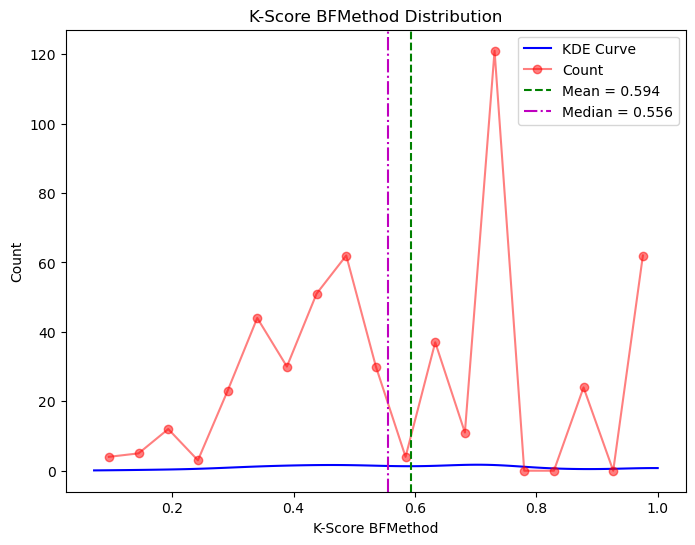

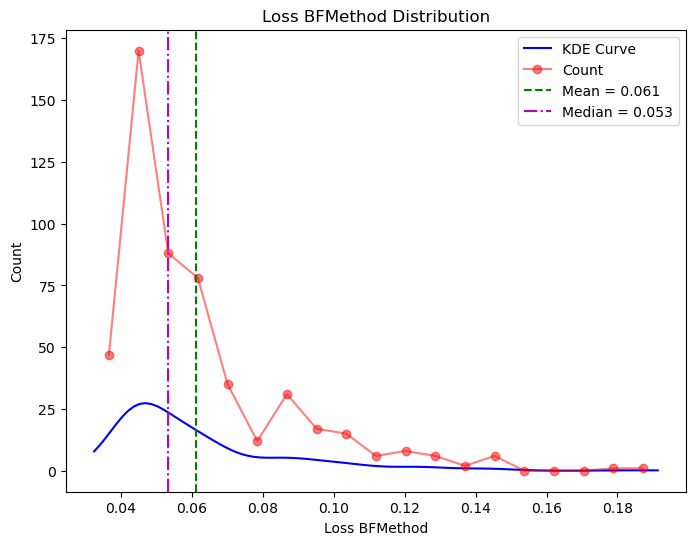

Dimension 128

NCC Interval		Average Loss
-0.1-0.0		0.3014 (34419 samples)
-0.2--0.1		0.3628 (39702 samples)
-0.3--0.2		0.3177 (18130 samples)
-0.4--0.3		0.3544 (10188 samples)
-0.5--0.4		0.8596 (5584 samples)
-0.6--0.5		0.9033 (2824 samples)
-0.7--0.6		0.6764 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.3292 (56807 samples)
0.1-0.2		0.3163 (37318 samples)
0.2-0.3		0.3168 (29110 samples)
0.3-0.4		0.2543 (15625 samples)
0.4-0.5		0.2527 (10735 samples)
0.5-0.6		0.2082 (6430 samples)
0.6-0.7		0.1645 (3432 samples)
0.7-0.8		0.1373 (1584 samples)
0.8-0.9		0.1204 (608 samples)
0.9-1.0		0.0067 (611 samples)


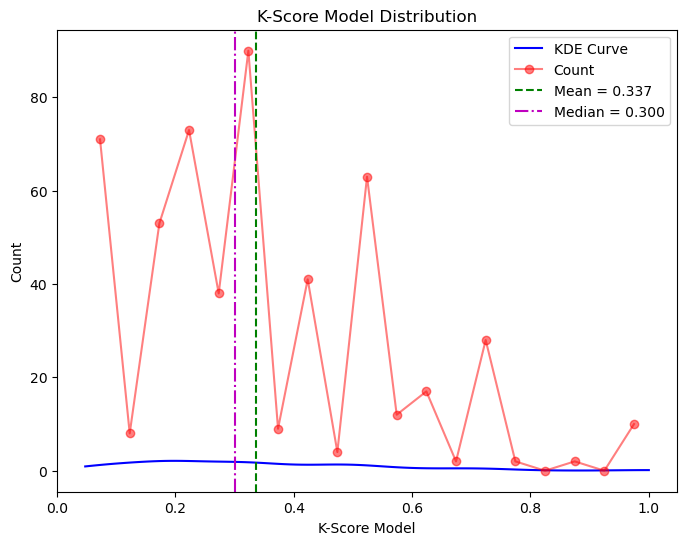

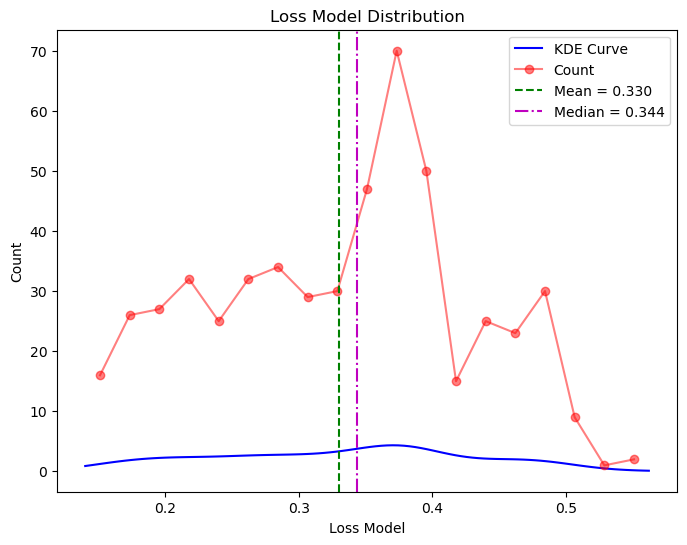


NCC Interval		Average Loss
-0.1-0.0		0.0453 (34419 samples)
-0.2--0.1		0.0641 (39702 samples)
-0.3--0.2		0.0856 (18130 samples)
-0.4--0.3		0.1076 (10188 samples)
-0.5--0.4		0.2135 (5584 samples)
-0.6--0.5		0.2488 (2824 samples)
-0.7--0.6		0.2799 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0441 (56807 samples)
0.1-0.2		0.0455 (37318 samples)
0.2-0.3		0.0479 (29110 samples)
0.3-0.4		0.0569 (15625 samples)
0.4-0.5		0.0546 (10735 samples)
0.5-0.6		0.0608 (6430 samples)
0.6-0.7		0.0598 (3432 samples)
0.7-0.8		0.0696 (1584 samples)
0.8-0.9		0.0565 (608 samples)
0.9-1.0		0.0039 (611 samples)


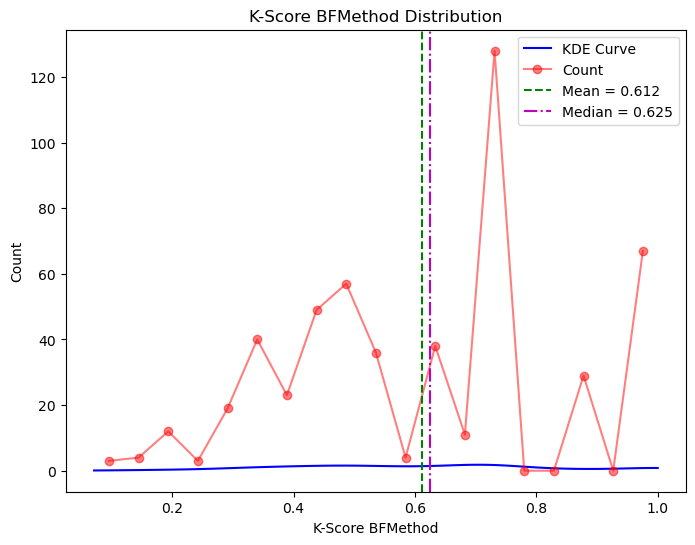

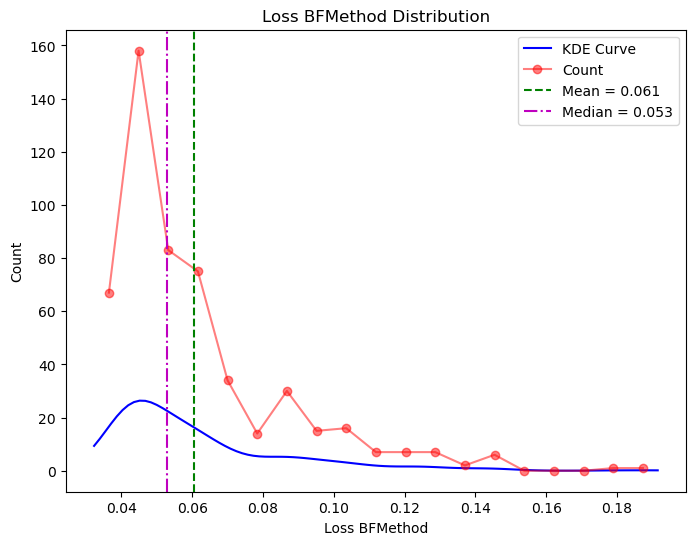

Dimension 192

NCC Interval		Average Loss
-0.1-0.0		0.2837 (34419 samples)
-0.2--0.1		0.2840 (39702 samples)
-0.3--0.2		0.3085 (18130 samples)
-0.4--0.3		0.3653 (10188 samples)
-0.5--0.4		0.5154 (5584 samples)
-0.6--0.5		0.4604 (2824 samples)
-0.7--0.6		0.5431 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2866 (56807 samples)
0.1-0.2		0.2808 (37318 samples)
0.2-0.3		0.2655 (29110 samples)
0.3-0.4		0.2379 (15625 samples)
0.4-0.5		0.2109 (10735 samples)
0.5-0.6		0.1838 (6430 samples)
0.6-0.7		0.1436 (3432 samples)
0.7-0.8		0.1274 (1584 samples)
0.8-0.9		0.0895 (608 samples)
0.9-1.0		0.0107 (611 samples)


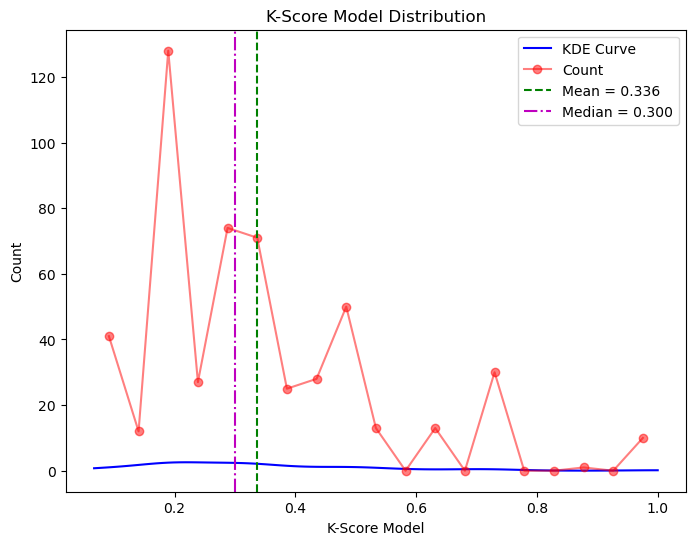

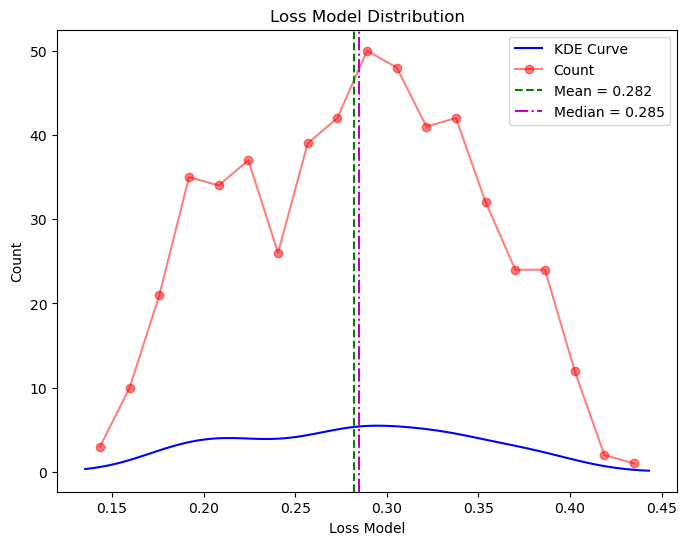


NCC Interval		Average Loss
-0.1-0.0		0.0453 (34419 samples)
-0.2--0.1		0.0641 (39702 samples)
-0.3--0.2		0.0856 (18130 samples)
-0.4--0.3		0.1076 (10188 samples)
-0.5--0.4		0.2135 (5584 samples)
-0.6--0.5		0.2488 (2824 samples)
-0.7--0.6		0.2799 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0441 (56807 samples)
0.1-0.2		0.0455 (37318 samples)
0.2-0.3		0.0479 (29110 samples)
0.3-0.4		0.0569 (15625 samples)
0.4-0.5		0.0546 (10735 samples)
0.5-0.6		0.0608 (6430 samples)
0.6-0.7		0.0598 (3432 samples)
0.7-0.8		0.0696 (1584 samples)
0.8-0.9		0.0565 (608 samples)
0.9-1.0		0.0039 (611 samples)


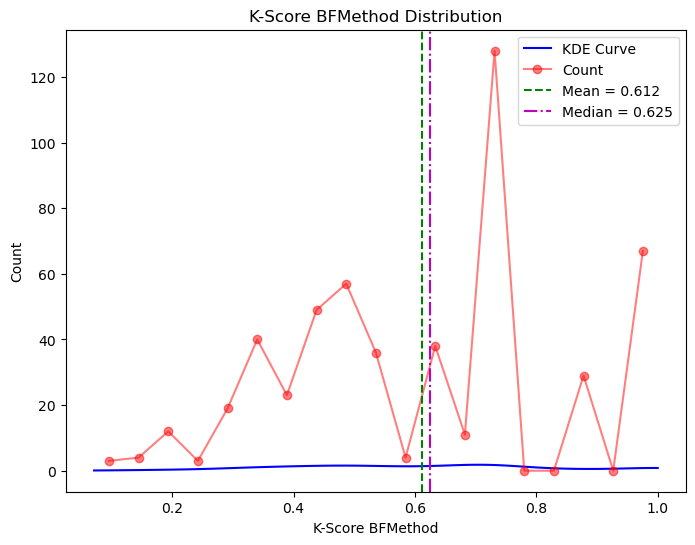

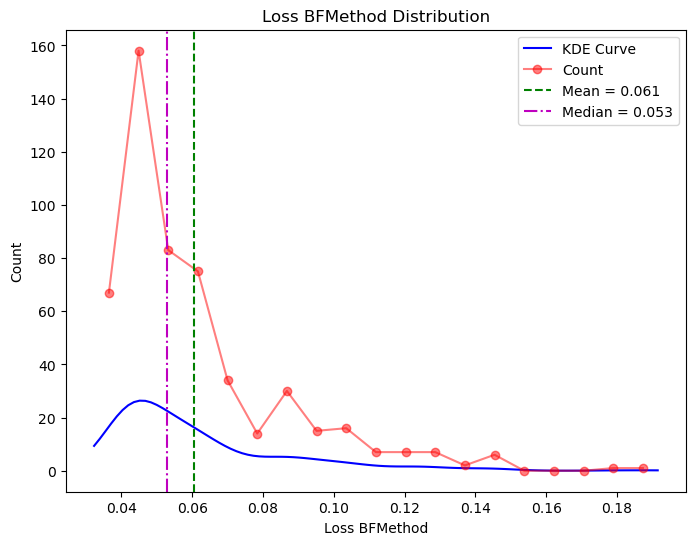

Dimension 256

NCC Interval		Average Loss
-0.1-0.0		0.2055 (34419 samples)
-0.2--0.1		0.2355 (39702 samples)
-0.3--0.2		0.2311 (18130 samples)
-0.4--0.3		0.2738 (10188 samples)
-0.5--0.4		0.6654 (5584 samples)
-0.6--0.5		0.6561 (2824 samples)
-0.7--0.6		0.5576 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2172 (56807 samples)
0.1-0.2		0.2135 (37318 samples)
0.2-0.3		0.2094 (29110 samples)
0.3-0.4		0.2080 (15625 samples)
0.4-0.5		0.2029 (10735 samples)
0.5-0.6		0.2008 (6430 samples)
0.6-0.7		0.1734 (3432 samples)
0.7-0.8		0.1524 (1584 samples)
0.8-0.9		0.1157 (608 samples)
0.9-1.0		0.0081 (611 samples)


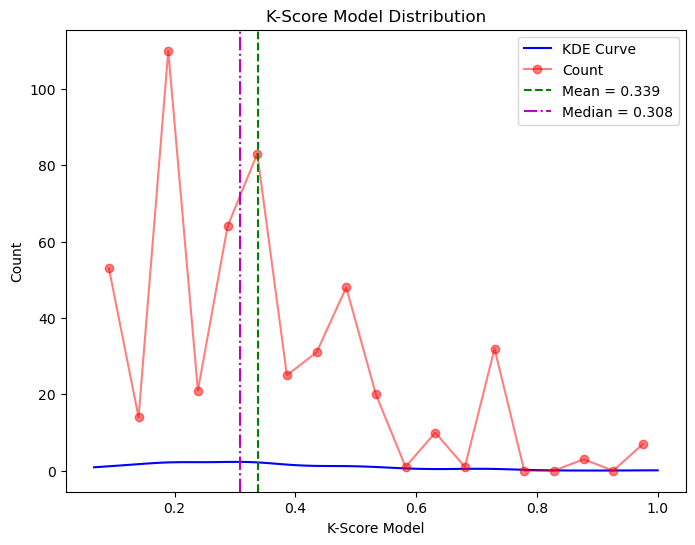

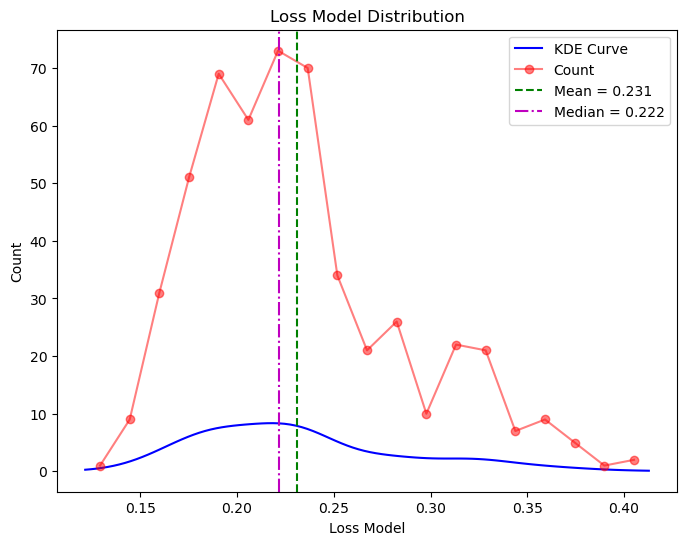


NCC Interval		Average Loss
-0.1-0.0		0.0453 (34419 samples)
-0.2--0.1		0.0641 (39702 samples)
-0.3--0.2		0.0856 (18130 samples)
-0.4--0.3		0.1076 (10188 samples)
-0.5--0.4		0.2135 (5584 samples)
-0.6--0.5		0.2488 (2824 samples)
-0.7--0.6		0.2799 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0441 (56807 samples)
0.1-0.2		0.0455 (37318 samples)
0.2-0.3		0.0479 (29110 samples)
0.3-0.4		0.0569 (15625 samples)
0.4-0.5		0.0546 (10735 samples)
0.5-0.6		0.0608 (6430 samples)
0.6-0.7		0.0598 (3432 samples)
0.7-0.8		0.0696 (1584 samples)
0.8-0.9		0.0565 (608 samples)
0.9-1.0		0.0039 (611 samples)


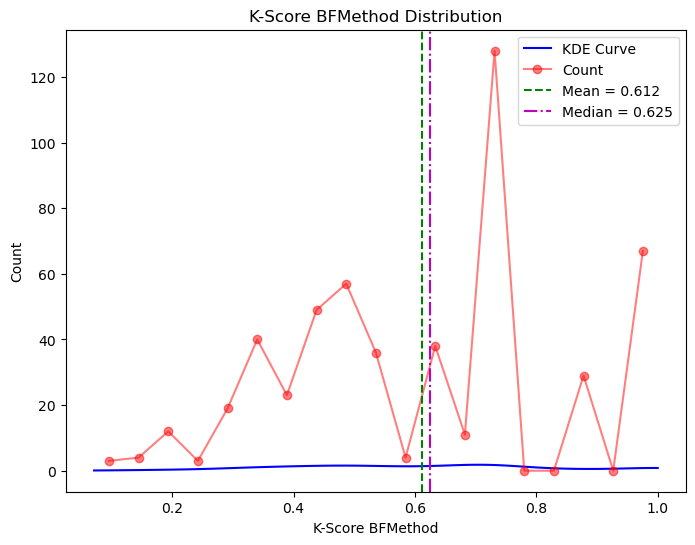

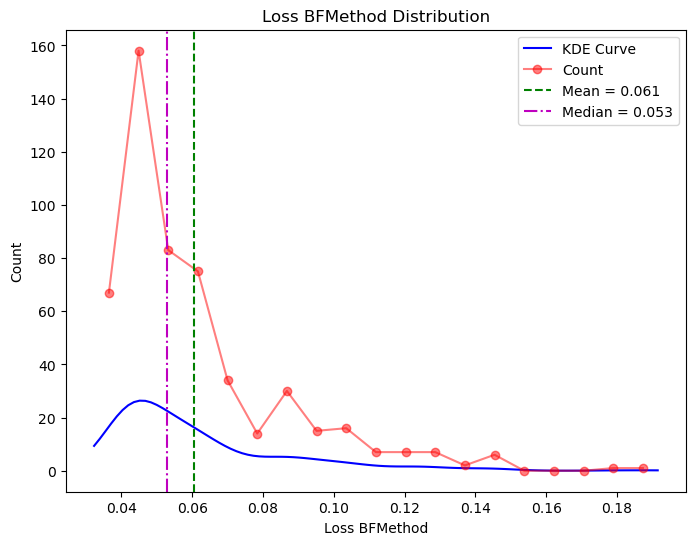

Dimension 384

NCC Interval		Average Loss
-0.1-0.0		0.3202 (34419 samples)
-0.2--0.1		0.3145 (39702 samples)
-0.3--0.2		0.3395 (18130 samples)
-0.4--0.3		0.3730 (10188 samples)
-0.5--0.4		0.5249 (5584 samples)
-0.6--0.5		0.5122 (2824 samples)
-0.7--0.6		0.5614 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.3205 (56807 samples)
0.1-0.2		0.3082 (37318 samples)
0.2-0.3		0.2840 (29110 samples)
0.3-0.4		0.2435 (15625 samples)
0.4-0.5		0.2060 (10735 samples)
0.5-0.6		0.1870 (6430 samples)
0.6-0.7		0.1560 (3432 samples)
0.7-0.8		0.1470 (1584 samples)
0.8-0.9		0.0984 (608 samples)
0.9-1.0		0.0105 (611 samples)


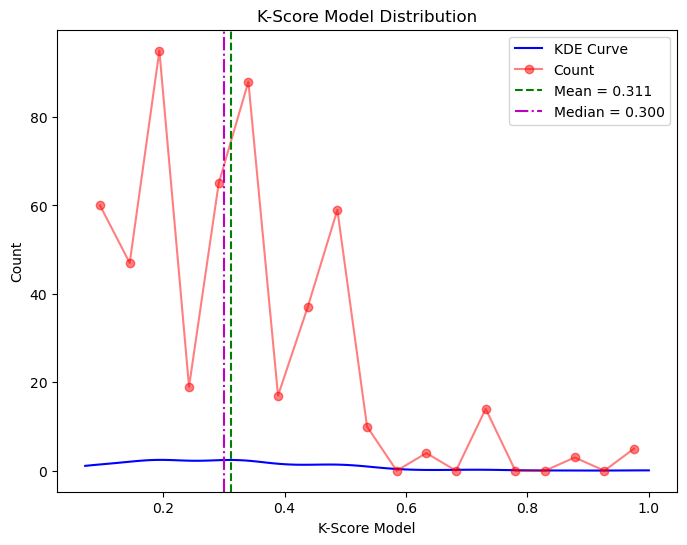

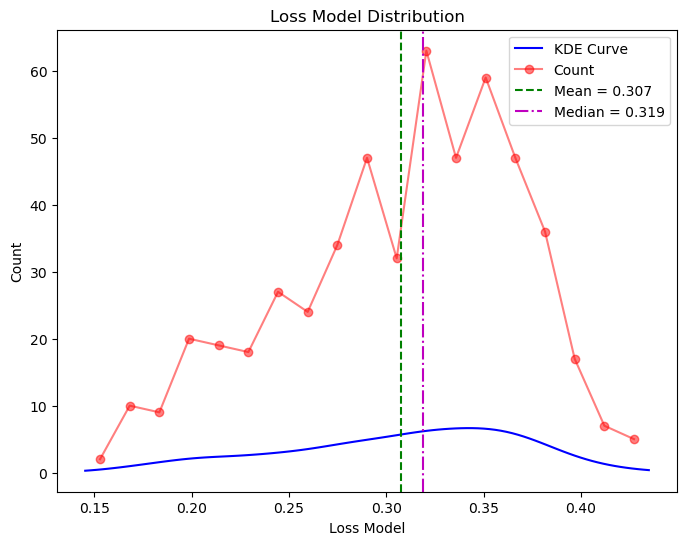


NCC Interval		Average Loss
-0.1-0.0		0.0453 (34419 samples)
-0.2--0.1		0.0641 (39702 samples)
-0.3--0.2		0.0856 (18130 samples)
-0.4--0.3		0.1076 (10188 samples)
-0.5--0.4		0.2135 (5584 samples)
-0.6--0.5		0.2488 (2824 samples)
-0.7--0.6		0.2799 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0441 (56807 samples)
0.1-0.2		0.0455 (37318 samples)
0.2-0.3		0.0479 (29110 samples)
0.3-0.4		0.0569 (15625 samples)
0.4-0.5		0.0546 (10735 samples)
0.5-0.6		0.0608 (6430 samples)
0.6-0.7		0.0598 (3432 samples)
0.7-0.8		0.0696 (1584 samples)
0.8-0.9		0.0565 (608 samples)
0.9-1.0		0.0039 (611 samples)


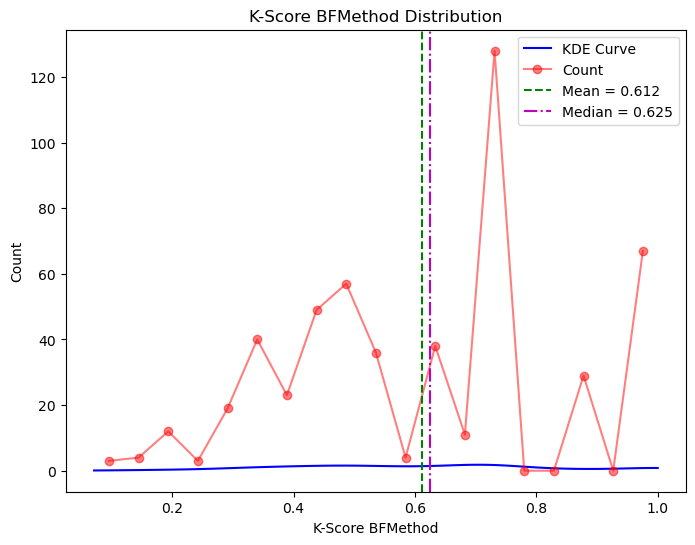

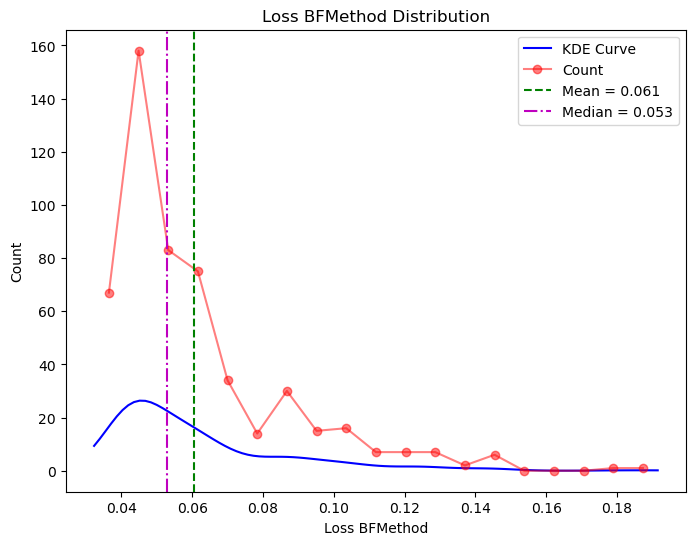

Dimension 512

NCC Interval		Average Loss
-0.1-0.0		0.1943 (34419 samples)
-0.2--0.1		0.2059 (39702 samples)
-0.3--0.2		0.2256 (18130 samples)
-0.4--0.3		0.2834 (10188 samples)
-0.5--0.4		0.5128 (5584 samples)
-0.6--0.5		0.5260 (2824 samples)
-0.7--0.6		0.5187 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2044 (56807 samples)
0.1-0.2		0.1948 (37318 samples)
0.2-0.3		0.2098 (29110 samples)
0.3-0.4		0.2006 (15625 samples)
0.4-0.5		0.1930 (10735 samples)
0.5-0.6		0.1846 (6430 samples)
0.6-0.7		0.1609 (3432 samples)
0.7-0.8		0.1516 (1584 samples)
0.8-0.9		0.1054 (608 samples)
0.9-1.0		0.0026 (611 samples)


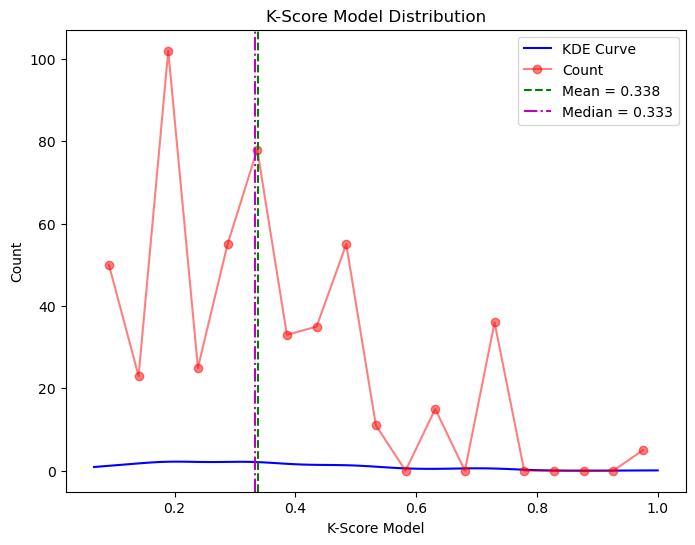

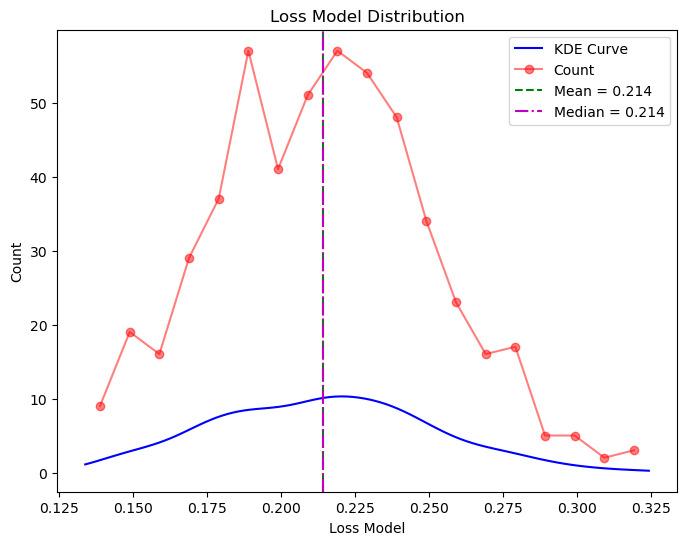


NCC Interval		Average Loss
-0.1-0.0		0.0453 (34419 samples)
-0.2--0.1		0.0641 (39702 samples)
-0.3--0.2		0.0856 (18130 samples)
-0.4--0.3		0.1076 (10188 samples)
-0.5--0.4		0.2135 (5584 samples)
-0.6--0.5		0.2488 (2824 samples)
-0.7--0.6		0.2799 (422 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0441 (56807 samples)
0.1-0.2		0.0455 (37318 samples)
0.2-0.3		0.0479 (29110 samples)
0.3-0.4		0.0569 (15625 samples)
0.4-0.5		0.0546 (10735 samples)
0.5-0.6		0.0608 (6430 samples)
0.6-0.7		0.0598 (3432 samples)
0.7-0.8		0.0696 (1584 samples)
0.8-0.9		0.0565 (608 samples)
0.9-1.0		0.0039 (611 samples)


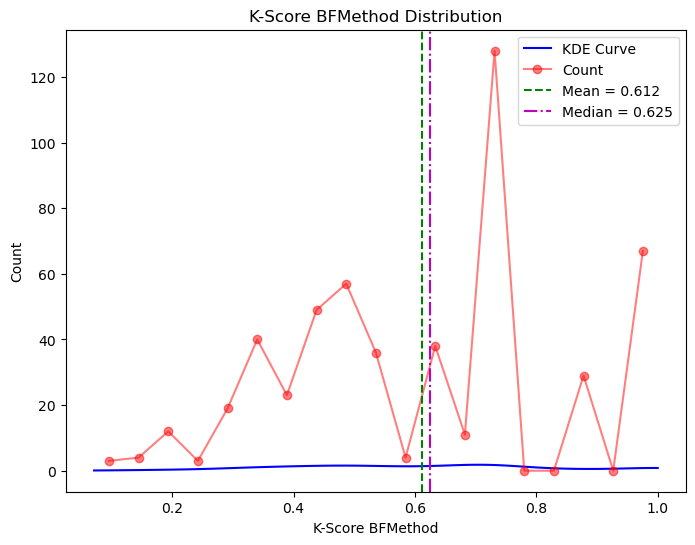

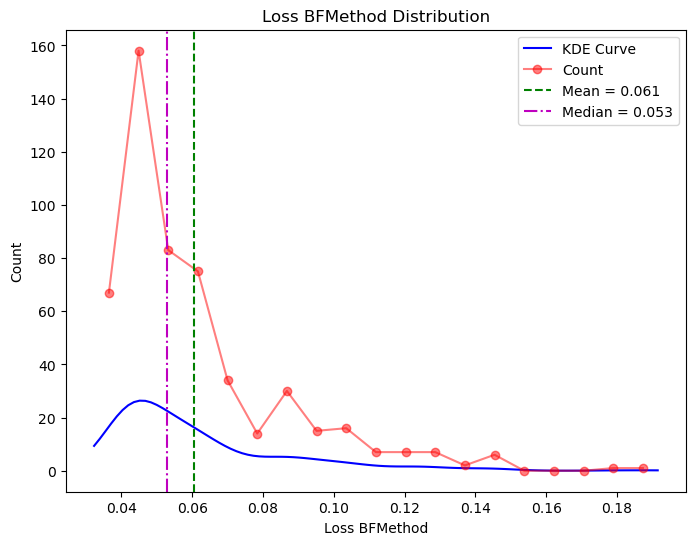

In [6]:
#--------------------Visualisation across dataset across dimensions-------------------
dimensions = [32, 64, 128, 192, 256, 384, 512]

input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:
    print(f"Dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_2.pt'), weights_only=True))

    model.eval()

    kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_model(testSample, input_dataset, model, k)

    imgcalc.loss_per_ncc_score(ncc_loss_dict)
    imgplt.plot_score_distribution(kscores, "K-Score Model")
    imgplt.plot_score_distribution(losses, "Loss Model")
    
    if dim <= len(testSample):
        matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
        kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)

        imgcalc.loss_per_ncc_score(ncc_loss_dict)
        imgplt.plot_score_distribution(kscores, "K-Score BFMethod")
        imgplt.plot_score_distribution(losses, "Loss BFMethod")

In [7]:
# -----------------------------Before transforming output embedding matrices-----------------------------
dim = 128
embeddingType = f"pencorr_{dim}"

model = models.SimpleCNN(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                 f'best_model_{imageType}_{dim}d_2.pt'), weights_only=True))

model.eval()
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Pencorr (A'A) and NCC (G):", mean_squared_difference)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Model: {mean_squared_difference}")

Mean Squared Difference of Pencorr (A'A) and NCC (G): 0.00715005810648017

Mean Squared Difference of Model and NCC (G): 0.1639594629367201
Mean Squared Difference of Model and Pencorr (A'A): 0.1439748476410039

Printing matrices

Matrix G: [[ 1.          0.33333337  0.7320509  ... -0.15983188 -0.15983188
  -0.24407101]
 [ 0.33333337  1.          0.7320509  ... -0.15983188 -0.15983188
  -0.24407107]
 [ 0.7320509   0.7320509   1.         ... -0.02985746 -0.02985746
  -0.12712848]
 ...
 [-0.15983188 -0.15983188 -0.02985746 ...  1.          0.64705884
   0.58776844]
 [-0.15983188 -0.15983188 -0.02985746 ...  0.64705884  1.
   0.48191714]
 [-0.24407101 -0.24407107 -0.12712848 ...  0.58776844  0.48191714
   1.        ]]

Matrix A'A (Pencorr): [[ 1.          0.30870054  0.63502134 ... -0.12332915 -0.10612115
  -0.22349462]
 [ 0.30870054  1.          0.54878227 ... -0.15996517 -0.08644592
  -0.23666728]
 [ 0.63502134  0.54878227  1.         ... -0.01023721 -0.01046551
  -0.11487031]
 ...
 [-0

In [8]:
#-----------------After transforming output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix_transformed.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix_transformed.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
     

print(f"\nPrinting matrices after transformation")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix_transformed}, error: {error_model}")

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_transformed[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Transformed Model: {mean_squared_difference}")

# magnitude = np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
# print("magnitude: ", magnitude)
# vector = model_transformed[index1].detach().cpu().numpy()/magnitude
# print("vector after normalisation: ", vector)

# mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], vector)
# print(f"Mean Squared Difference of Pencorr (A) and Normalised TransformedModel: {mean_squared_difference}")
# magnitude = np.linalg.norm(vector)
# print("magnitude: ", magnitude)

Difference between matrices

Mean Squared Difference of Model and NCC (G): 0.16999590329014946
Mean Squared Difference of Model and Pencorr (A'A): 0.16294984296979673

Printing matrices after transformation

Matrix G: [[ 1.          0.33333337  0.7320509  ... -0.15983188 -0.15983188
  -0.24407101]
 [ 0.33333337  1.          0.7320509  ... -0.15983188 -0.15983188
  -0.24407107]
 [ 0.7320509   0.7320509   1.         ... -0.02985746 -0.02985746
  -0.12712848]
 ...
 [-0.15983188 -0.15983188 -0.02985746 ...  1.          0.64705884
   0.58776844]
 [-0.15983188 -0.15983188 -0.02985746 ...  0.64705884  1.
   0.48191714]
 [-0.24407101 -0.24407107 -0.12712848 ...  0.58776844  0.48191714
   1.        ]]

Matrix A'A (Pencorr): [[ 1.          0.30870054  0.63502134 ... -0.12332915 -0.10612115
  -0.22349462]
 [ 0.30870054  1.          0.54878227 ... -0.15996517 -0.08644592
  -0.23666728]
 [ 0.63502134  0.54878227  1.         ... -0.01023721 -0.01046551
  -0.11487031]
 ...
 [-0.12332915 -0.15996517 -


MSE between vector embeddings of Pencorr (A) and Model:


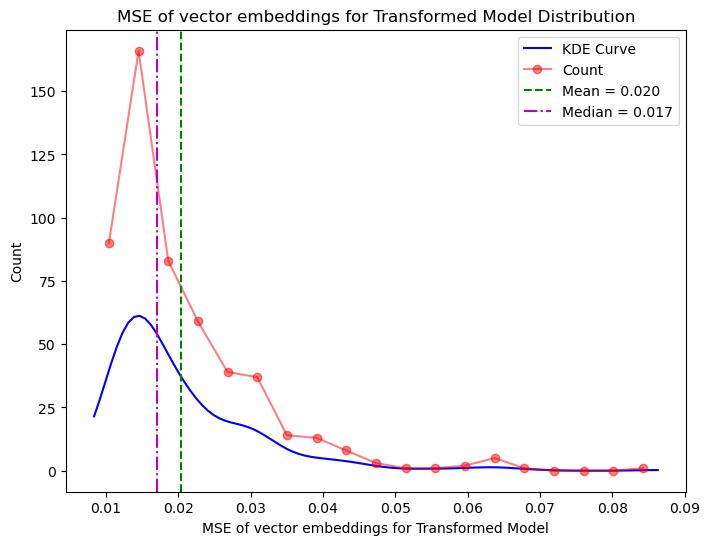

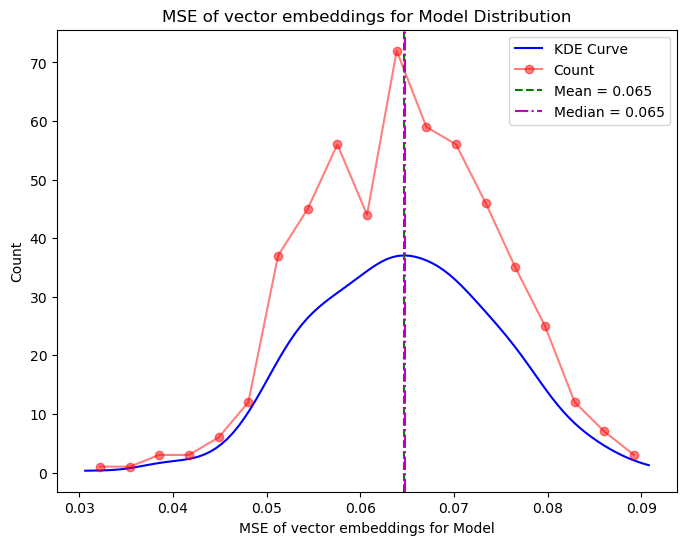

In [8]:
# ------------------------ MSE of embedding across dataset -----------------------------
num = len(input_dataset)
MSE_transformed = []
MSE_original = []
print(f"\nMSE between vector embeddings of Pencorr (A) and Model:")   
for i in range(num):
    difference_squared = (matrixA[:,i] - model_transformed[i].detach().cpu().numpy()) ** 2
    mean_squared_difference = np.sum(difference_squared) / difference_squared.size
    #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
    MSE_transformed.append(mean_squared_difference)
    difference_squared = (matrixA[:,i] - model_vectors[i].detach().cpu().numpy()) ** 2
    mean_squared_difference = np.sum(difference_squared) / difference_squared.size
    #print(f"Original matrix of Index {i}: {mean_squared_difference}")
    MSE_original.append(mean_squared_difference)
    
imgplt.plot_score_distribution(MSE_transformed, "MSE of vector embeddings for Transformed Model")
imgplt.plot_score_distribution(MSE_original, "MSE of vector embeddings for Model")


MSE between vector embeddings of dimension 32 for Pencorr (A) and Model:


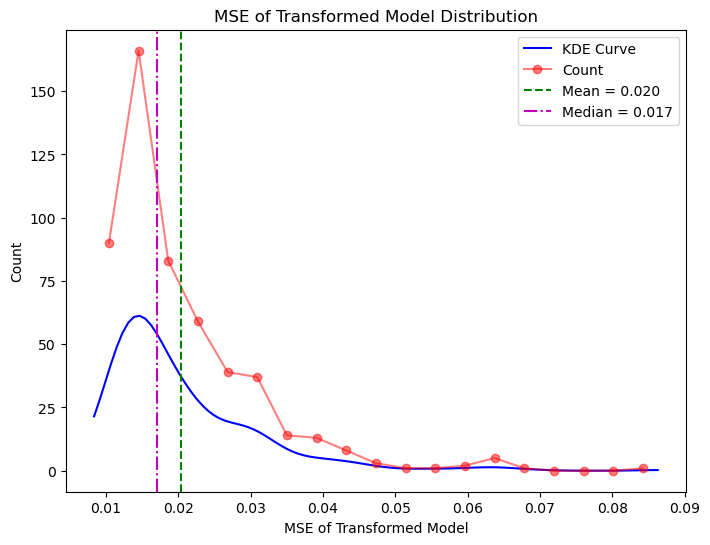

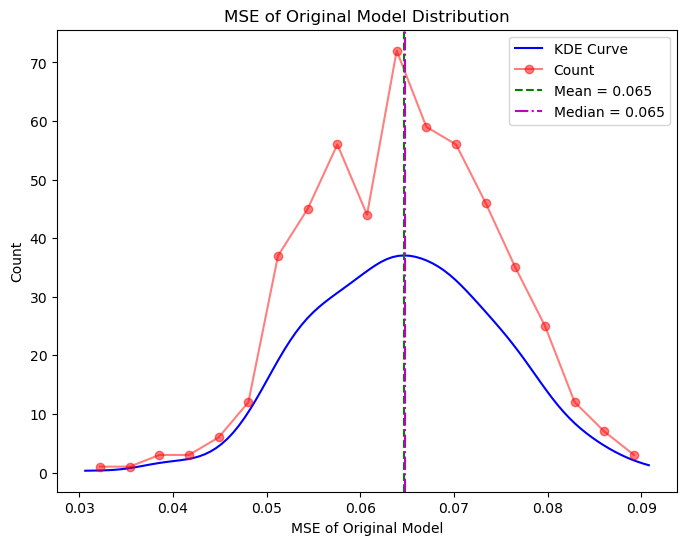


MSE between vector embeddings of dimension 64 for Pencorr (A) and Model:


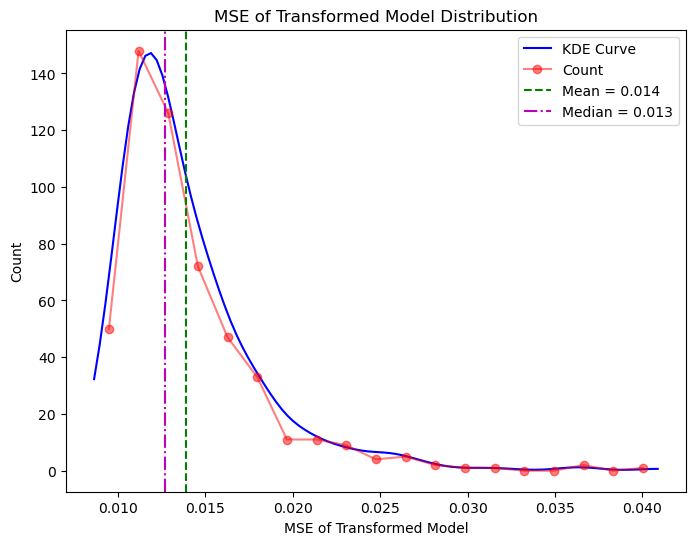

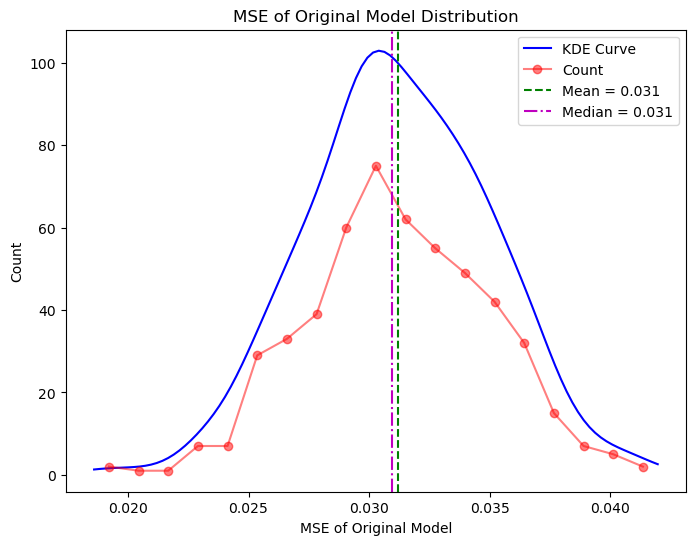


MSE between vector embeddings of dimension 128 for Pencorr (A) and Model:


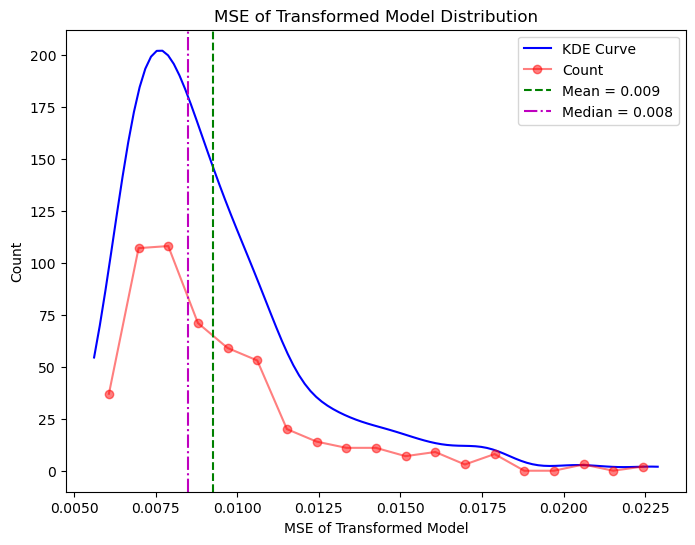

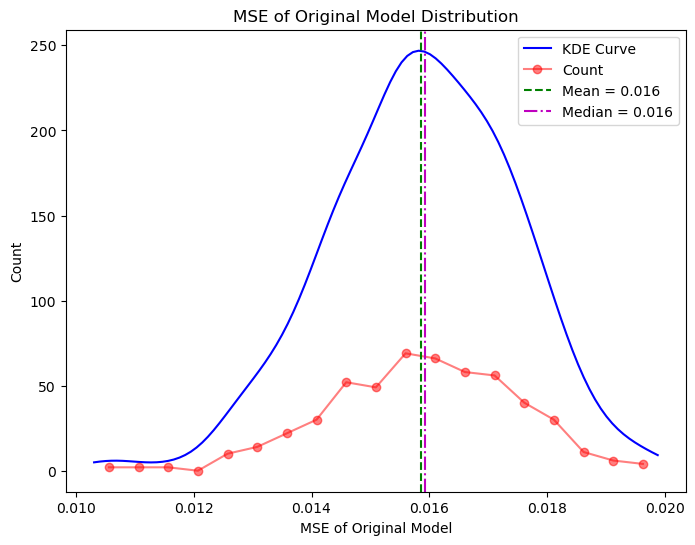


MSE between vector embeddings of dimension 256 for Pencorr (A) and Model:


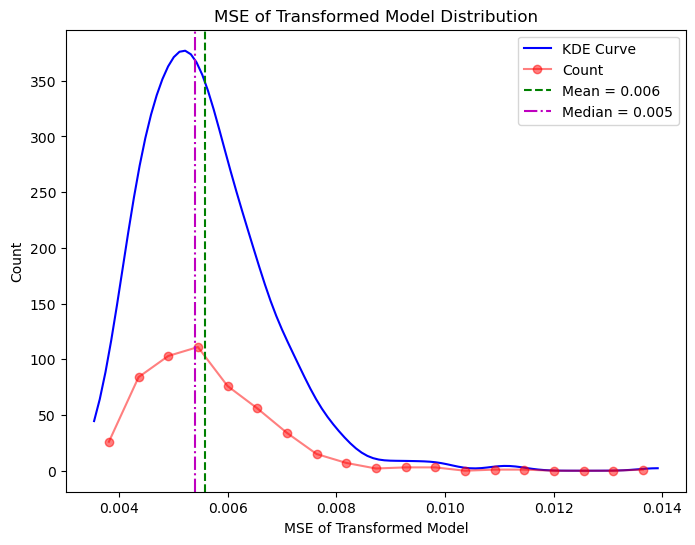

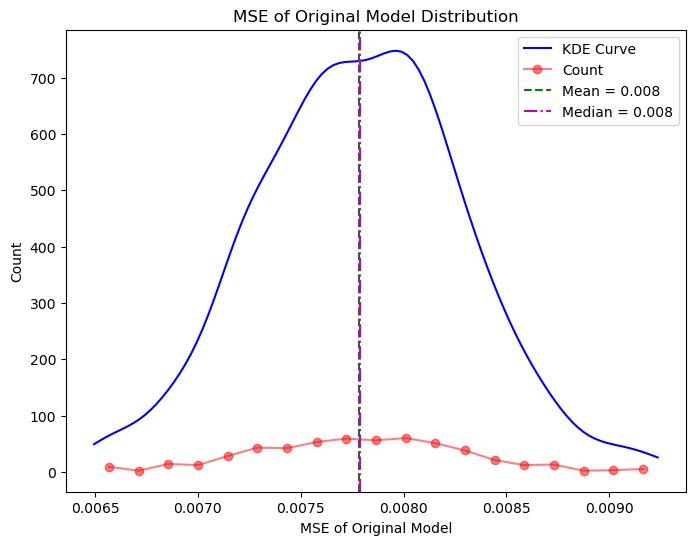


MSE between vector embeddings of dimension 384 for Pencorr (A) and Model:


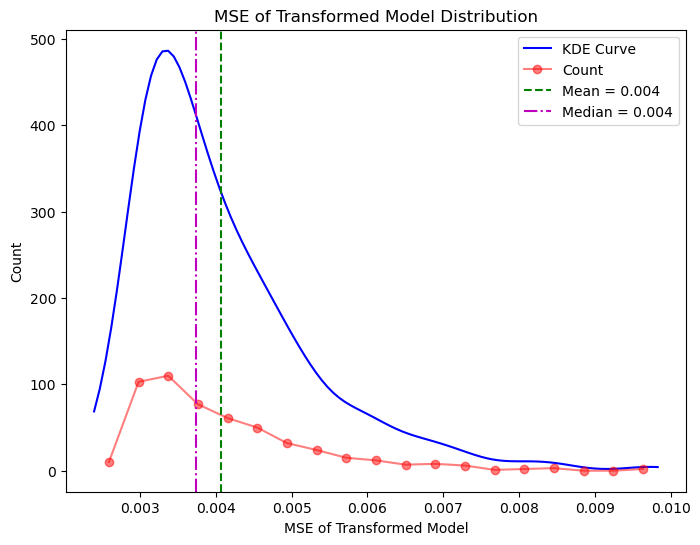

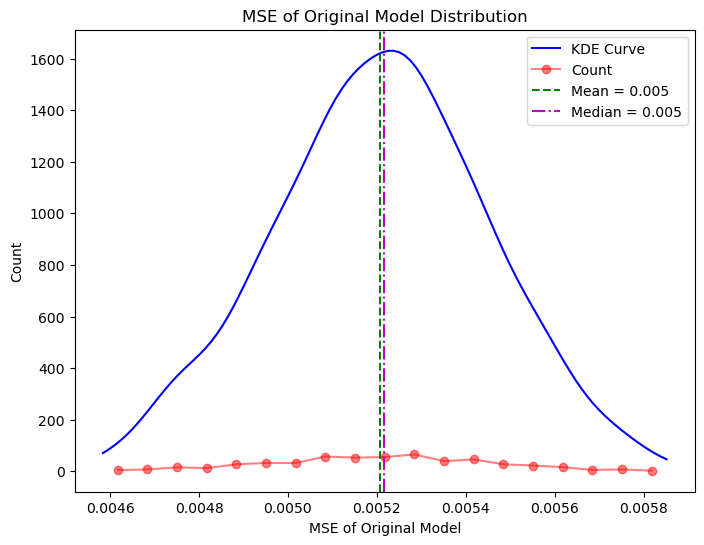


MSE between vector embeddings of dimension 512 for Pencorr (A) and Model:


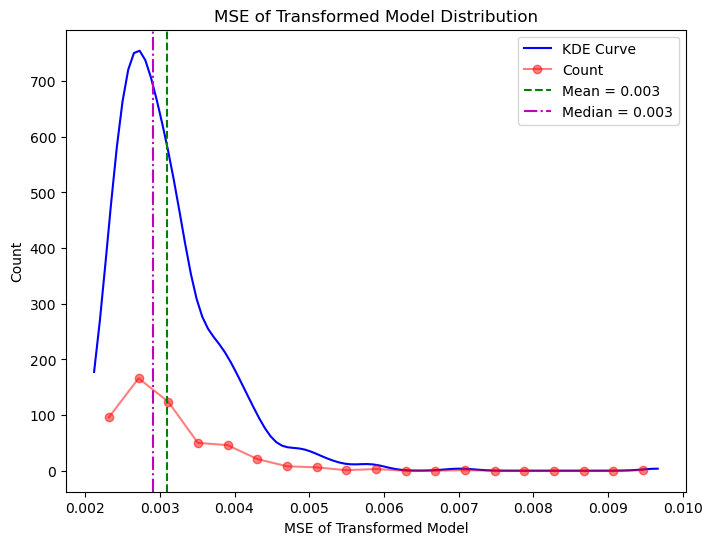

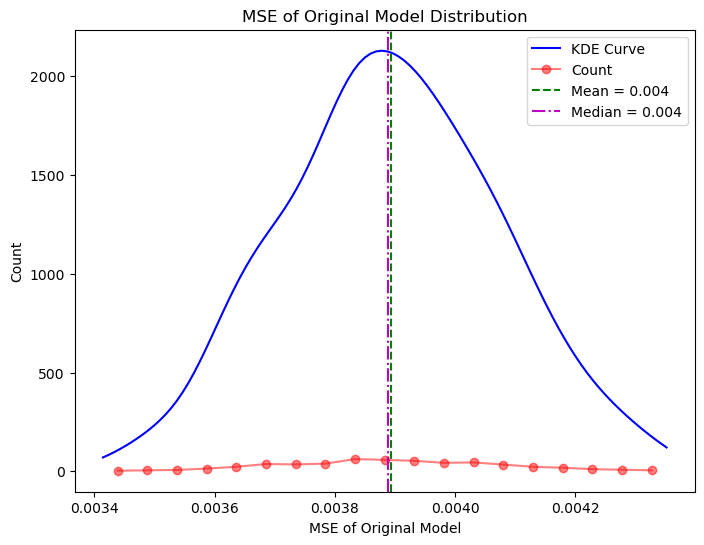

In [9]:
# ------------------------ MSE of embedding across dimensions across dataset -----------------------------
dimensions = [32, 64, 128, 256, 384, 512]
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_2.pt'), weights_only=True))

    model.eval()
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)
    
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    MSE_transformed = []
    MSE_original = []
    print(f"\nMSE between vector embeddings of dimension {dim} for Pencorr (A) and Model:")   
    for i in range(num):
        difference_squared = (matrixA[:,i] - model_transformed[i].detach().cpu().numpy()) ** 2
        mean_squared_difference = np.sum(difference_squared) / difference_squared.size
        #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed.append(mean_squared_difference)
        difference_squared = (matrixA[:,i] - model_vectors[i].detach().cpu().numpy()) ** 2
        mean_squared_difference = np.sum(difference_squared) / difference_squared.size
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_original.append(mean_squared_difference)
        
    imgplt.plot_score_distribution(MSE_transformed, f"MSE of Transformed Model")
    imgplt.plot_score_distribution(MSE_original, f"MSE of Original Model")

In [ ]:
# -------------------- Using normalized embedding loss function to determine dimension--------------------
def find_optimal_dim(losses, eps=0.05): 
    """ losses: dict {dimension: L(d)} """
    L_inf = min(losses.values()) 
    for d in sorted(losses.keys()): 
        if (losses[d] - L_inf)/L_inf <= eps: 
            return d 
    return max(losses.keys())
